In [1]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from Bio import SeqIO

import passenger

In [2]:
blast_paths = glob("passenger-blast/outname_[5-7]*.tsv")
chigy = passenger.CHIGY_HC
max_mutation_count = 10
max_n_count = 10
# 2 or 3 gap segments, which corresponds to 0 or 1 indels
allowable_gap_segment_counts = [2, 3]

In [3]:
passenger.test_summarize_alignment()
passenger.test_correct_alignment()
passenger.test_summarize_alignment()
passenger.test_compute_mutation_counts_by_base()

Text(0.5, 1.0, 'Histogram of CONSCOUNT values for input/outname_5_S1_R1_001_atleast-2.fastq.gz')

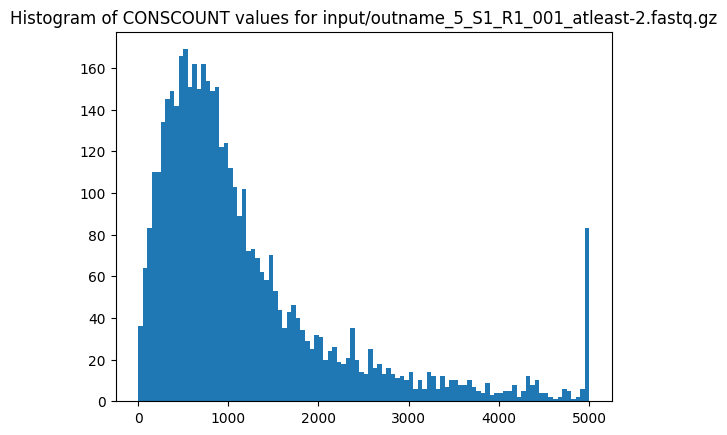

In [4]:
import re, gzip
pattern = re.compile(r"CONSCOUNT=(\d+)")

fastq_gz_path = "input/outname_5_S1_R1_001_atleast-2.fastq.gz"

max_count = 5000

conscount_values = []
conscount_truncated = []
sequence_lengths = []

# Parse the fastq file
with gzip.open(fastq_gz_path, "rt") as handle:
    for record in SeqIO.parse(handle, "fastq"):
        sequence_lengths.append(len(record.seq))
        match = pattern.search(record.description)
        if match:
            conscount = int(match.group(1))
            # All values greater than max_count are set to max_count
            conscount_values.append(conscount)
            conscount_truncated.append(min(conscount, max_count))

# Create a pandas Series
conscount_series = pd.Series(conscount_values)
#print(conscount_series.describe())
# plt.hist(conscount_series) with log scale on x-axis
plt.hist(conscount_truncated, bins=100, range=(0, max_count + 1))
# set title to "Histogram of CONSCOUNT values"
plt.title(f"Histogram of CONSCOUNT values for {fastq_gz_path}")

Text(0.5, 1.0, 'Histogram of sequence lengths for input/outname_5_S1_R1_001_atleast-2.fastq.gz')

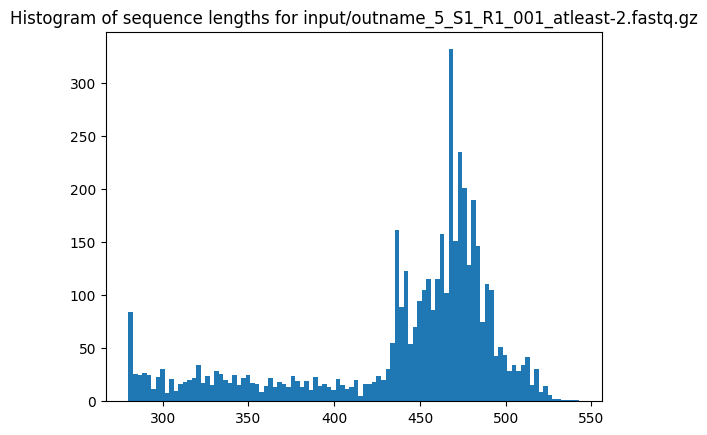

In [5]:
# make histogram of sequence lengths
plt.hist(sequence_lengths, bins=100)
plt.title(f"Histogram of sequence lengths for {fastq_gz_path}")

In [6]:
query_length = 20
blast_df = passenger.blast_df_of_blast_files(blast_paths, query_length)

Before filtering by length: 36475
After filtering by length: 35644
Note: multiple hits found in BLAST results for passenger-blast/outname_6_IgM_S2_R1_001_atleast-2.blast.tsv.
Original length: 35644
After dropping sequences with multiple hits: 35498



The following is an example of why we need to fix these. Presumably there is some PCR recombination happening. We get rid of these sequences.

In [7]:
with gzip.open("input/outname_6A_S2_R1_001_atleast-2.fastq.gz", "rt") as handle:
    for record in SeqIO.parse(handle, "fastq"):
        if "AGGAGAACAACAAAACG|PRCONS=Mus-p5-IgGa|CONSCOUNT=2|DUPCOUNT=1" in record.description:
            print(record.seq)

# We can see that this matches "AACCGGTGTGTACATTCCGA" twice.

GACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATGGTCATGTATCATCCTTTTTCTAGTAGCAACTGCAACCGGTGTGTACATTCCGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGCCAAAACAACAGCCCCATCNGTCTATCCACTGGAGATCGGAAGAGCGTCGTGGTGGGAAANAGTGTGNTTCGATCTAGGAGAACAAAAAAACGGATCTACGGGGACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATGGTCATGTATCATCCTTTTTCTAGTAGCAACTGCAACCGGTGTGTACATTCCGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGCCAAAACAACAG


In [8]:
blast_df.sort_values("dataset", inplace=True)

read_comparison_df = pd.DataFrame(blast_df["dataset"].value_counts().sort_index())
read_comparison_df.rename(columns={"count": "chigy_count"}, inplace=True)
read_comparison_df["fasta_count"] = 0

for dataset in read_comparison_df.index:
    fasta_path = f"passenger-blast/{dataset}.fasta"
    # count the number of reads in the fasta file
    read_comparison_df.loc[dataset, "fasta_count"] = len(list(SeqIO.parse(fasta_path, "fasta")))

read_comparison_df["chigy_fraction"] = read_comparison_df["chigy_count"] / read_comparison_df["fasta_count"]

read_comparison_df

,chigy_count,fasta_count,chigy_fraction
dataset,,,
outname_5_IgG_S4_R1_001_atleast-2,5888,24692,0.238458
outname_5_IgM_S1_R1_001_atleast-2,7136,15827,0.450875
outname_5_S1_R1_001_atleast-2,961,4539,0.211721
outname_6A_S2_R1_001_atleast-2,2431,8123,0.299274
outname_6_IgG_S5_R1_001_atleast-2,3938,14512,0.271362
outname_6_IgM_S2_R1_001_atleast-2,4672,9592,0.487073
outname_7B_S3_R1_001_atleast-2,2198,7715,0.284900
outname_7_IgG_S6_R1_001_atleast-2,3396,12214,0.278042
outname_7_IgM_S3_R1_001_atleast-2,4878,9468,0.515209


In [9]:
processed_stop_df = chigy.processed_stop_df_of_blast_df(blast_df)
# processed_stop_df

processed_stop_df["dataset"].value_counts().sort_index()

dataset
outname_5_IgG_S4_R1_001_atleast-2    5888
outname_5_IgM_S1_R1_001_atleast-2    7136
outname_5_S1_R1_001_atleast-2         961
outname_6A_S2_R1_001_atleast-2       2431
outname_6_IgG_S5_R1_001_atleast-2    3938
outname_6_IgM_S2_R1_001_atleast-2    4672
outname_7B_S3_R1_001_atleast-2       2198
outname_7_IgG_S6_R1_001_atleast-2    3396
outname_7_IgM_S3_R1_001_atleast-2    4878
Name: count, dtype: int64

In [10]:
processed_stop_df["mutation_count"].value_counts()[:20].sort_index()

mutation_count
0      5659
1      9766
2      6300
3      4270
4      2780
5      1828
6      1161
7       652
8       411
9       272
10      128
11       61
12       47
119      59
120      67
121      55
122      43
123      47
124      61
127      50
Name: count, dtype: int64

In [11]:
chigy_believable = processed_stop_df[(processed_stop_df["mutation_count"] < max_mutation_count) & (processed_stop_df["n_count"] < max_n_count) & (processed_stop_df["bookended_by_gaps"] == True)].copy()

chigy_believable


,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,...,dataset,sequence,gap_segment_count,bookended_by_gaps,mutation_positions,mutation_bases,n_positions,mutation_count,n_count,Sequence number
12511,GTCAACAGGGGTGGACT|PRCONS=Mus-p5-IgGa|CONSCOUNT...,100.0,20,0,0,1,20,110,129,0.000059,...,outname_5_IgG_S4_R1_001_atleast-2,GTCACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTG...,2,True,[140],[T],[155],1,1,12511
13032,GGCAGCTGAAGTCATGT|PRCONS=Mus-p5-IgGa|CONSCOUNT...,100.0,20,0,0,1,20,108,127,0.000059,...,outname_5_IgG_S4_R1_001_atleast-2,GACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAG...,2,True,"[102, 105, 197, 218, 273]","[G, C, C, T, T]",[],5,0,13032
13035,ATATGTGGTAGACACAA|PRCONS=Mus-p5-IgGa|CONSCOUNT...,100.0,20,0,0,1,20,108,127,0.000059,...,outname_5_IgG_S4_R1_001_atleast-2,GACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAG...,2,True,[212],[C],[],1,0,13035
13037,AAGAGCAGAGAAGTAAA|PRCONS=Mus-p5-IgGb|CONSCOUNT...,100.0,20,0,0,1,20,98,117,0.000059,...,outname_5_IgG_S4_R1_001_atleast-2,GAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACACAGTCTT...,2,True,"[132, 276]","[G, C]",[],2,0,13037
13040,TTTAGCCGTCTAGTTGG|PRCONS=Mus-p5-IgGa|CONSCOUNT...,100.0,20,0,0,1,20,105,124,0.000059,...,outname_5_IgG_S4_R1_001_atleast-2,ATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACA...,2,True,"[146, 236, 237, 240, 248, 258, 280]","[A, T, T, T, A, T, T]",[],7,0,13040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28893,ATAGTACAAGGCAGACA|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,76,95,0.000027,...,outname_7_IgM_S3_R1_001_atleast-2,GAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATGGTCA...,2,True,"[155, 231, 232, 275, 277, 280]","[G, C, G, T, T, C]",[],6,0,28893
28894,ACAAGAGCATCGTGAGC|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,100,119,0.000027,...,outname_7_IgM_S3_R1_001_atleast-2,GGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACACAGTC...,2,True,[287],[C],[],1,0,28894
28895,ATCGACGTAGCCATCGA|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,108,127,0.000027,...,outname_7_IgM_S3_R1_001_atleast-2,GACATAACAGCAAGAGAGTGTCTGGTTAGTCTCAAGGAAGACTGAG...,2,True,[],[],[],0,0,28895
28897,ATACTTCACGGCTGGTA|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,74,93,0.000027,...,outname_7_IgM_S3_R1_001_atleast-2,AAGGAAGACTGAGACACAGTCTTAGAAAGCACCATGGGATGGTCAT...,2,True,"[137, 157, 161, 166, 235, 271, 274, 286]","[A, T, G, C, T, T, T, T]",[],8,0,28897


In [12]:
# Find representatives of the various gap counts
representative_gap_counts = chigy_believable.drop_duplicates(subset=["gap_segment_count"])
representative_gap_counts = representative_gap_counts.sort_values(by=["gap_segment_count"])
chigy.pretty_print_alignments(representative_gap_counts)

> outname_5_IgG_S4_R1_001_atleast-2 12511
-------------------------------------------------------------------------------------------------------------------------------GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAG------------
                                                                                                                               ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||.|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||            
GTCA

In [13]:
chigy_believable = chigy_believable[chigy_believable["gap_segment_count"].isin(allowable_gap_segment_counts)]
chigy_believable["mutation_count"].value_counts().sort_index()

mutation_count
0    4599
1    8022
2    5090
3    3438
4    2284
5    1486
6     915
7     519
8     308
9     235
Name: count, dtype: int64

In [14]:
chigy_believable["dataset"].value_counts().sort_index()

dataset
outname_5_IgG_S4_R1_001_atleast-2    3446
outname_5_IgM_S1_R1_001_atleast-2    6578
outname_5_S1_R1_001_atleast-2         722
outname_6A_S2_R1_001_atleast-2       1749
outname_6_IgG_S5_R1_001_atleast-2    2263
outname_6_IgM_S2_R1_001_atleast-2    4336
outname_7B_S3_R1_001_atleast-2       1567
outname_7_IgG_S6_R1_001_atleast-2    1645
outname_7_IgM_S3_R1_001_atleast-2    4590
Name: count, dtype: int64

In [15]:
conscounts = chigy_believable["subject"].str.findall(r"CONSCOUNT=(\d+)").apply(lambda x: int(x[0]) if x else 0)
pd.DataFrame({"subject": chigy_believable["subject"], "conscount": conscounts, "n_count": chigy_believable["n_count"]}).to_csv("output/igh-conscount-vs-n-count.csv", index=False)

In [16]:
# Find representatives of the various gap counts
representative_mutation_counts = chigy_believable.drop_duplicates(subset=["mutation_count"])
representative_mutation_counts = representative_mutation_counts.sort_values(by=["mutation_count"])
chigy.pretty_print_alignments(representative_mutation_counts)

> outname_5_IgG_S4_R1_001_atleast-2 13030
--------------------------------------------------------------------------------------------------------------------------GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAG--------------------
                                                                                                                          |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||                   

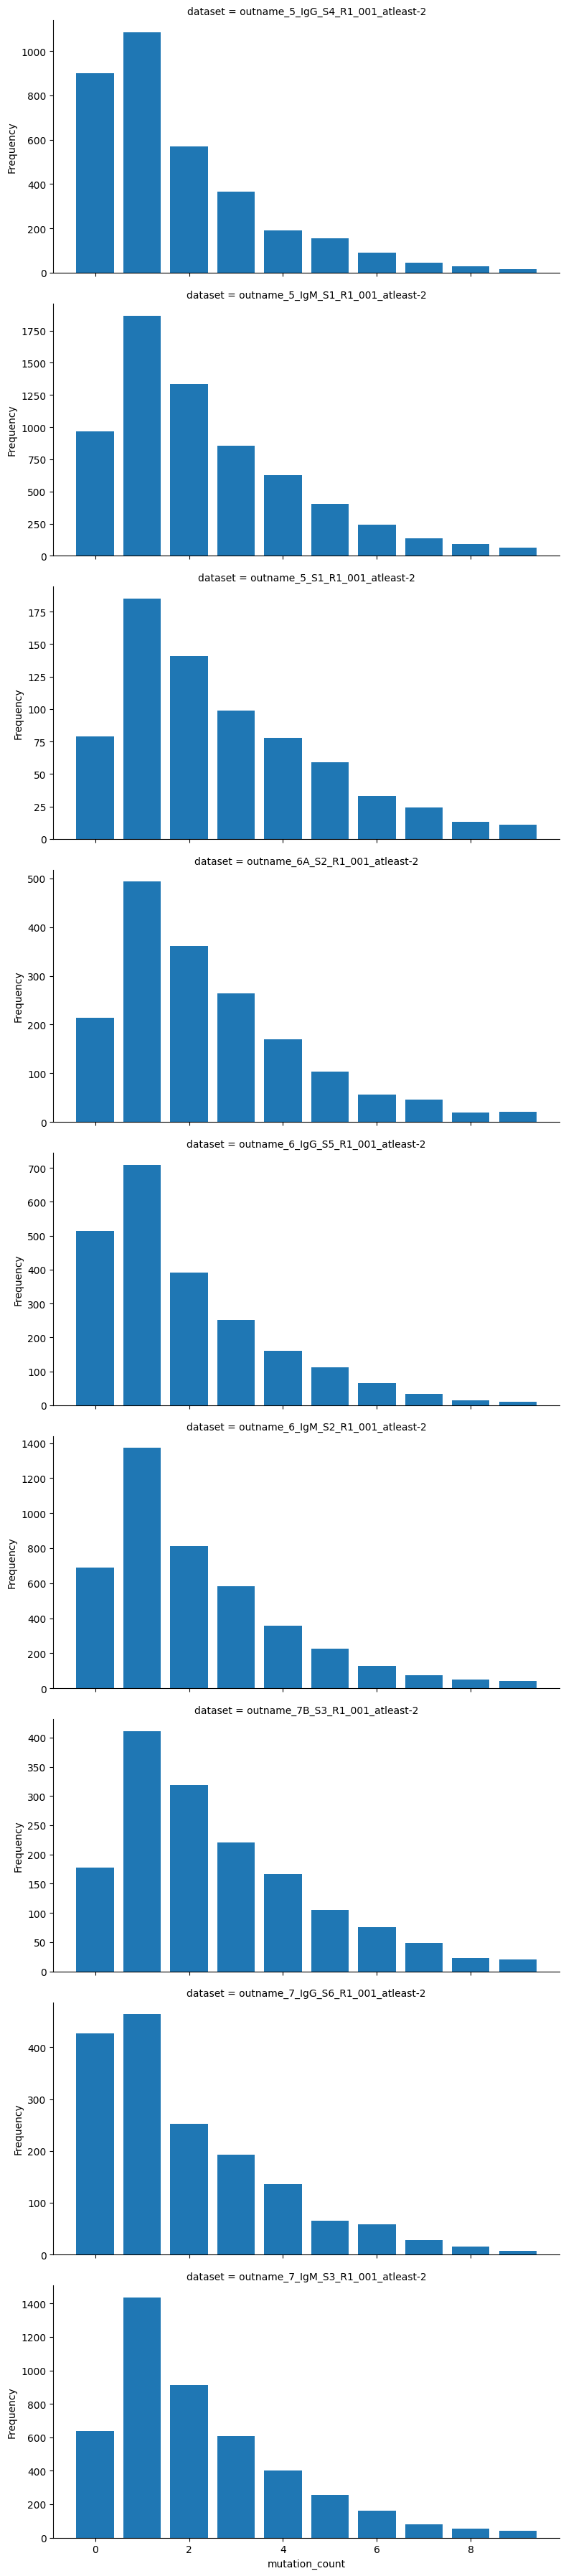

In [17]:
passenger.make_mutation_histogram(chigy_believable)

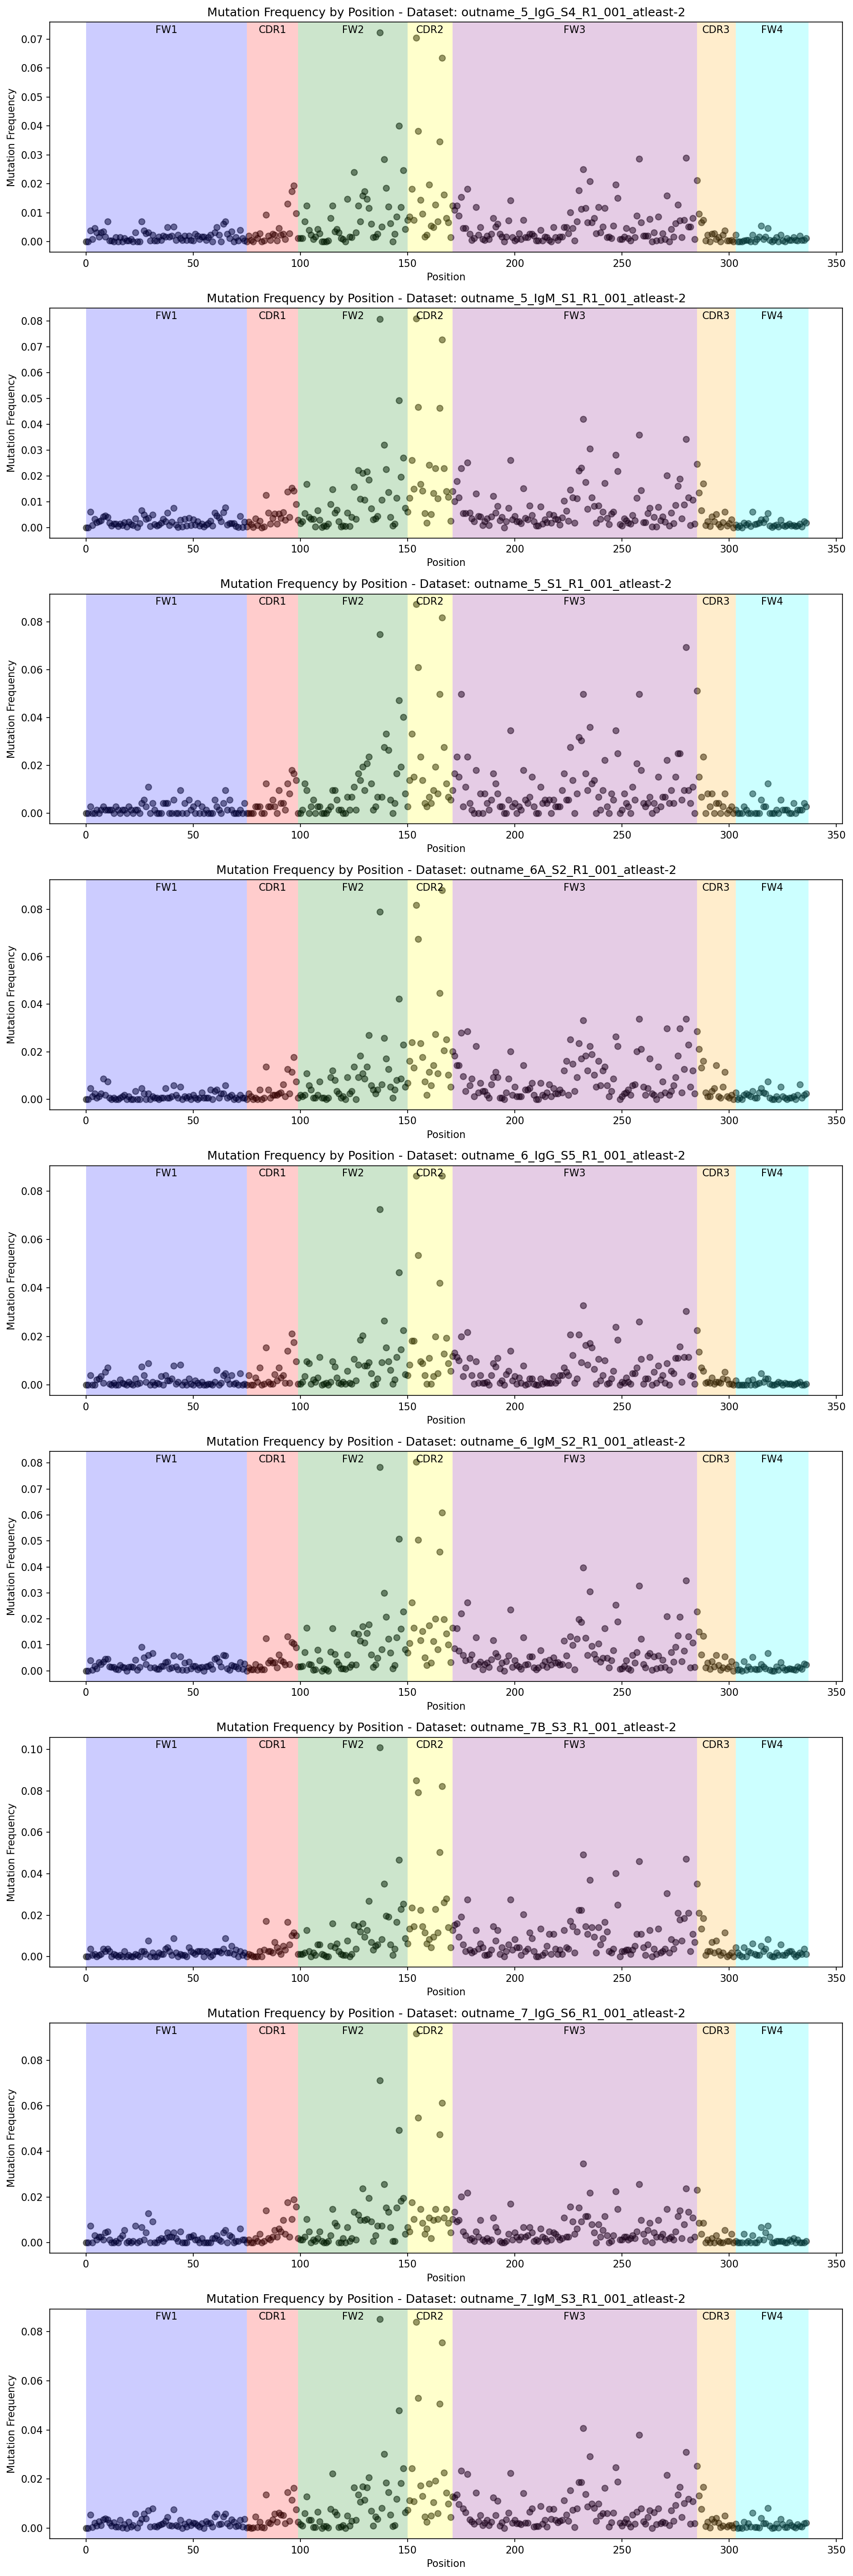

In [18]:
chigy.make_mutation_rate_plot(chigy_believable)


In [19]:
mut_counts_l = []
read_counts_l = []

for name, df in chigy_believable.groupby("dataset"):
    mut_counts = passenger.compute_mutation_counts_by_base(df, chigy.chigy_stop_trimmed)
    nickname = name[8:13]
    # trim off a trailing underscore if it exists
    if nickname[-1] == "_":
        nickname = nickname[:-1]
    mut_counts["nickname"] = nickname
    mut_counts_l.append(mut_counts)
    read_counts_l.append({"nickname": nickname, "read_count": len(df)})

read_counts_df = pd.DataFrame(read_counts_l)
read_counts_df.to_csv("output/igh_read_counts.csv", index=False)

mut_counts_df = pd.concat(mut_counts_l)
mut_counts_df.reset_index(names=["position"], inplace=True)
mut_counts_df = mut_counts_df[["nickname", "position", "A", "C", "G", "T"]]
mut_counts_df.to_csv("output/igh_counts_by_base.csv", index=False)
mut_counts_df

,nickname,position,A,C,G,T
0,5_IgG,0,0,0,-1,0
1,5_IgG,1,-1,0,0,0
2,5_IgG,2,10,3,-1,0
3,5_IgG,3,3,0,-1,0
4,5_IgG,4,12,3,1,-1
...,...,...,...,...,...,...
3028,7_IgM,332,0,-1,0,7
3029,7_IgM,333,0,1,3,-1
3030,7_IgM,334,0,-1,2,1
3031,7_IgM,335,-1,0,5,4


In [20]:
mutation_frequency_by_position = passenger.mutation_frequency_by_position_of(chigy_believable)
n_frequency_by_position = passenger.compute_thing_counts(chigy_believable, "n_positions") / len(chigy_believable)
# pad np array n_frequency_by_position with zeros to be as long as mutation_frequency_by_position
n_frequency_by_position = np.pad(n_frequency_by_position, (0, len(mutation_frequency_by_position) - len(n_frequency_by_position)))
mut_freq_df = pd.DataFrame({
    "mutation_frequency": mutation_frequency_by_position, 
    "N_frequency": n_frequency_by_position
})
mut_freq_df.to_csv("output/igh_n_frequency.csv", columns=["N_frequency"], index=False)
n_rich_df = mut_freq_df[mut_freq_df["N_frequency"] > 0.]
n_rich_df = n_rich_df.sort_values(by="mutation_frequency", ascending=False)
n_rich_df

,mutation_frequency,N_frequency
154,0.081573,0.008626
137,0.079566,0.005726
166,0.072353,0.009407
155,0.051978,0.006432
146,0.047182,0.003718
...,...,...
110,0.000186,0.000037
75,0.000112,0.000260
320,0.000037,0.000037
302,0.000037,0.000037


<Axes: xlabel='N_frequency', ylabel='mutation_frequency'>

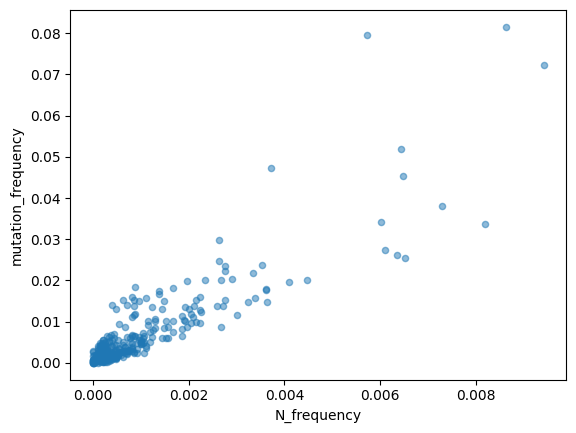

In [21]:
mut_freq_df.plot.scatter(x="N_frequency", y="mutation_frequency", alpha=0.5)